<a href="https://colab.research.google.com/github/diya0603/Image-Captioning-Project/blob/main/Poetic_TextGenertor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using GPT2 and FastAI libraries to generate a poem with a given seed word

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.3 MB/s eta 0:00:00


In [ ]:
# from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [ ]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [ ]:
ballads = get_text_files('', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 200 ballads in the dataset


In [ ]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [ ]:
# This function is designed to flatten a nested list, meaning it converts a list of lists into a single flat list.

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

all_ballads = flatten(ballads)

In [ ]:
# this class encapsulates the tokenization functionality provided by a Transformers tokenizer.
# The encodes method tokenizes input data and converts it into token IDs,
# while the decodes method converts token IDs back into a human-readable string.
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

# TitledStr - a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

In [ ]:
# creating a transformed list (tls) using the TfmdLists class, applying the TransformersTokenizer transformation to each element in the all_ballads list.

splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)


# The TfmdLists class in the fastai library is used to create a transformed list
# from a source list or collection of data.
# It provides a convenient way to apply one or more transformations to each element of the source list
# and create a new list with the transformed elements.

In [ ]:
show_at(tls.train, 0)

As we the withered ferns
By the roadway lying,
Time, the jester, spurns
All our prayers and prying --
All our tears and sighing,
Sorrow, change, and woe --
All our where-and-whying
For friends that come and go.
Life awakes and burns,
Age and death defying,
Till at last it learns
All but Love is dying;
Love's the trade we're plying,
God has willed it so;
Shrouds are what we're buying
For friends that come and go.
Man forever yearns
For the thing that's flying.
Everywhere he turns,
Men to dust are drying, --
Dust that wanders, eying
(With eyes that hardly glow)
New faces, dimly spying
For friends that come and go.
ENVOY
And thus we all are nighing
The truth we fear to know:
Death will end our crying
For friends that come and go.


In [ ]:
# bs and sl are variables representing the batch size and sequence length, respectively.
# The code then creates a DataLoaders object (dls) using the dataloaders() method of the TfmdLists object (tls)

bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

# The resulting dls object contains the data loaders ready for training or inference.
# These data loaders handle the batching, shuffling, and any necessary data transformations
# based on the configurations provided during their creation.

Token indices sequence length is longer than the specified maximum sequence length for this model (24233 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# display a batch of data samples. The max_n argument is set to 2,
# indicating that a maximum of 2 batches should be shown.

dls.show_batch(max_n=2)

,text,text_
0,"Oh the green glimmer of apples in the orchard,\nLamps in a wash of rain!\nOh the wet walk of my brown hen through the stackyard,\nOh tears on the window pane!\nNothing now will ripen the bright green apples,\nFull of disappointment and of rain,\nBrackish they will taste, of tears, when the yellow dapples\nOf autumn tell the withered tale again.\nAll round the yard it is cluck, my brown hen,\nCluck, and the rain-wet wings,\nCluck, my marigold bird, and again\nCluck for your yellow darlings.\nFor the grey rat found the gold thirteen\nHuddled away in the dark,\nFlutter for a moment, oh the beast is quick and keen,\nExtinct one yellow-fluffy spark.\nOnce I had a lover bright like running water,\nOnce his face was laughing like the sky;\nOpen like the sky looking down in all its laughter\nOn the buttercups, and the buttercups was I.\nWhat, then, is there hidden in the skirts of all the blossom?\nWhat is peeping from your wings, oh","the green glimmer of apples in the orchard,\nLamps in a wash of rain!\nOh the wet walk of my brown hen through the stackyard,\nOh tears on the window pane!\nNothing now will ripen the bright green apples,\nFull of disappointment and of rain,\nBrackish they will taste, of tears, when the yellow dapples\nOf autumn tell the withered tale again.\nAll round the yard it is cluck, my brown hen,\nCluck, and the rain-wet wings,\nCluck, my marigold bird, and again\nCluck for your yellow darlings.\nFor the grey rat found the gold thirteen\nHuddled away in the dark,\nFlutter for a moment, oh the beast is quick and keen,\nExtinct one yellow-fluffy spark.\nOnce I had a lover bright like running water,\nOnce his face was laughing like the sky;\nOpen like the sky looking down in all its laughter\nOn the buttercups, and the buttercups was I.\nWhat, then, is there hidden in the skirts of all the blossom?\nWhat is peeping from your wings, oh"
1,"on with a speed divine\nWhile the gay bells echo with peal on peal,\nWe may carol the praises of ruby wine;\nBut when, with perverseness most condign,\nIn the same harsh snowstorm, cold and keen,\nMy auto stops at the six-mile sign--\nThen ho! For a gallon of gasoline!\nENVOY\nWhen yacht or Coach Club fellows dine\nWe may carol the praises of ruby wine;\nBut when Automobile Clubmen convene\nThen ho! For a gallon of gasoline!\nSubmitted by John MartinThis life--one was thinking to-day,\nIn the midst of a medley of fancies -\nIs a game, and the board where we play\nGreen earth with her poppies and pansies.\nLet manque be faded romances,\nBe passe remorse and regret;\nHearts dance with the wheel as it dances -\nThe wheel of Dame Fortune's roulette.\nThe lover will stake as he may\nHis heart on his Peggies and Nancies;\nThe girl has her beauty to lay;\nThe saint has his prayers and his trances;\nThe poet bets endless expanses\nIn Dreamland","with a speed divine\nWhile the gay bells echo with peal on peal,\nWe may carol the praises of ruby wine;\nBut when, with perverseness most condign,\nIn the same harsh snowstorm, cold and keen,\nMy auto stops at the six-mile sign--\nThen ho! For a gallon of gasoline!\nENVOY\nWhen yacht or Coach Club fellows dine\nWe may carol the praises of ruby wine;\nBut when Automobile Clubmen convene\nThen ho! For a gallon of gasoline!\nSubmitted by John MartinThis life--one was thinking to-day,\nIn the midst of a medley of fancies -\nIs a game, and the board where we play\nGreen earth with her poppies and pansies.\nLet manque be faded romances,\nBe passe remorse and regret;\nHearts dance with the wheel as it dances -\nThe wheel of Dame Fortune's roulette.\nThe lover will stake as he may\nHis heart on his Peggies and Nancies;\nThe girl has her beauty to lay;\nThe saint has his prayers and his trances;\nThe poet bets endless expanses\nIn Dreamland;"


The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them in some regularization scheme). To work inside the fastai training loop, we will need to drop those using a Callback: we use those to alter the behavior of the training loop.

Here we need to write the event after_pred and replace self.learn.pred (which contains the predictions that will be passed to the loss function) by just its first element. In callbacks, there is a shortcut that lets you access any of the underlying Learner attributes so we can write self.pred[0] instead of self.learn.pred[0]. That shortcut only works for read access, not write, so we have to write self.learn.pred on the right side (otherwise we would set a pred attribute in the Callback).

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()


In [ ]:
learn.validate()

(#2) [4.223470687866211,68.27001953125]

SuggestedLRs(valley=0.00015848931798245758)

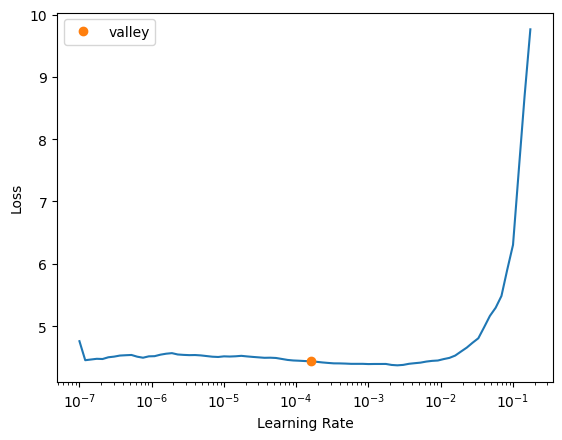

In [ ]:
# finding a learning rate
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.320867,4.049267,57.355415,00:42
1,4.131721,3.801173,44.753658,00:42
2,3.937371,3.614334,37.126606,00:43
3,3.721434,3.446965,31.404919,00:43
4,3.495777,3.285112,26.711987,00:43
5,3.308166,3.167917,23.757946,00:43
6,3.108266,3.073973,21.627668,00:43
7,2.964395,3.017796,20.446169,00:44
8,2.878400,2.996534,20.016048,00:43
9,2.820334,2.991268,19.910912,00:44


In [ ]:
# save the model
learn.path = Path('/content/drive/MyDrive/6 sem projects/DL Project')
learn.export('PoeticTextGenerator.pkl')

In [ ]:
prompt = 'Two dogs are playing with each other' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 7])

In [ ]:
prompt = "2 dogs are playing with each other"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True, temperature=0.5)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
2 dogs are playing with each other.
"They've got all sorts of things to eat,
And they're all hungry."
Then Alfred said, "But where shall I find them?"
King Alfred smiled, and said: "I will go with my men
To White Horse Vale, where I will see them play
For the first time since I came of age."And the King went with his men to the Vale
Of the Broken Heart.And there he found them all
